In [22]:
risk_sub = risk_12[:, 3] # 1-13 HCC risk
label_sub = tr_label[:, 0] * (tr_time[:, 0] <= 31)
cutoff_1 = 0.1129
cutoff_2 = 0.1542

highrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] >= cutoff_1 and risk_sub[i] < cutoff_2]
lowrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] < cutoff_1]
TP = sum(highrisk_1)
FP = len(highrisk_1) - TP
FN = sum(lowrisk_1)
TN = len(lowrisk_1) - FN
print('Low-mid classification: ')
print('sensitivity: ', str(TP/(TP + FN)))
print('specificity: ', str(TN/(TN + FP)))
print('PPV: ', str(TP/(TP + FP)))
print('NPV: ', str(TN/(TN + FN)))

highrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] >= cutoff_2]
lowrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] < cutoff_2]
TP = sum(highrisk_1)
FP = len(highrisk_1) - TP
FN = sum(lowrisk_1)
TN = len(lowrisk_1) - FN
print('Low-mid classification: ')
print('sensitivity: ', str(TP/(TP + FN)))
print('specificity: ', str(TN/(TN + FP)))
print('PPV: ', str(TP/(TP + FP)))
print('NPV: ', str(TN/(TN + FN)))

Low-mid classification: 
sensitivity:  0.5652173913043478
specificity:  0.7181372549019608
PPV:  0.02748414376321353
NPV:  0.9915397631133672
Low-mid classification: 
sensitivity:  0.7628865979381443
specificity:  0.7957094100438811
PPV:  0.15010141987829614
NPV:  0.9861027190332327


In [56]:
import sys

sys.argv = ['mod', 'PreCar', 'xx', '6', '10000']
# cutoff_adjustment = adj

_EPSILON = 1e-08

#### <<< Warning suppression>>> ###
# import warnings
# warnings.filterwarnings('deprecated')
#### This makes the resulting log a lot nicer BUT could produce errors in very, very rare and unexpected circumstances. 

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
import sys
import json
import time as timepackage

from sklearn.model_selection import train_test_split

import import_data as impt

from class_DeepLongitudinal import Model_Longitudinal_Attention

from utils_eval             import c_index, brier_score
from utils_log              import save_logging, load_logging
from utils_helper           import f_get_minibatch, f_get_boosted_trainset



def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    """
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    """
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):

    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)

    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])

    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred

            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]

    return risk_all

## cmd args: 
# now only one argument is needed
# this will be something like "PreCar"
# and the machine will know to find all relevant materials from the "PreCar" directory





### the following codes read model training results plus needed data from Model_Training.py
# and theoretically can be used to re-construct everything needed? 

'''
saver.restore(sess, sys.argv[1])
with open(sys.argv[2]) as p: 
    params = json.load(p)
'''

# argv[1] is the data_mode: eg if PreCar, the program will read it from the PreCar file
# argv[2], if left empty, will choose the most recent log
# if argv[2] is specified, will use the string to find relevant log

data_mode_name = sys.argv[1]

if len(sys.argv) < 6: 
    # this means no argv[2] is given; we use the most recent log
    # to do so, for now lets just use max argument
    # firstly, take out all log.json documents
    logs = os.listdir(data_mode_name)
    # logs is a list of all available logs; find the most recent one...
    target_dir = data_mode_name + '/' + max(logs)
    print('Using the most recent _log.json by default, since no specification is given. ')
else: 
    # assume that argv[2] has specified a keyword, use the keyword to identify logs
    logs = os.listdir(data_mode_name)
    matched = [i for i in logs if sys.argv[2] in i]
    if len(matched) >= 2: 
        print('Warning: more than one log is matched with the keyword and the most recent one will be used. ')
        matched = max(matched)
    target_dir = data_mode_name + '/' + matched[0]


# read log
with open(target_dir + '/' + '_log.json') as p: 
    params = json.load(p)
mod_dir = target_dir + '/' + 'model'

# print(type(params))
new_parser = params['new_parser']
dataset_info = params['dataset_info']
evaluation_info = params['evaluation_info']
model_configs = params['model_configs']
eval_configs = params['eval_configs']
time_tag = params['new_parser']['time_tag']

dirs = dataset_info
test_dir = []
data_mode = data_mode_name
for key in list(dirs.keys()): 
    if key == data_mode: 
        train_dir = dirs[key]
    else: 
        test_dir.append(dirs[key])

(tr_x_dim, tr_x_dim_cont, tr_x_dim_bin), (tr_data, tr_time, tr_label), (tr_mask1, tr_mask2, tr_mask3), (tr_data_mi), (tr_id), tr_feat_list = impt.import_dataset(path = train_dir, bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

(te_x_dim, te_x_dim_cont, te_x_dim_bin), (te_data, te_time, te_label), (te_mask1, te_mask2, te_mask3), (te_data_mi), (te_id), te_feat_list = impt.import_dataset(path = test_dir[0], bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

(tea_x_dim, tea_x_dim_cont, tea_x_dim_bin), (tea_data, tea_time, tea_label), (tea_mask1, tea_mask2, tea_mask3), (tea_data_mi), (tea_id), tea_feat_list = impt.import_dataset(path = test_dir[1], bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

pred_time = evaluation_info['pred_time'] # prediction time (in months)
eval_time = evaluation_info['eval_time'] # months evaluation time (for C-index and Brier-Score)

_, num_Event, num_Category  = np.shape(tr_mask1)  # dim of mask3: [subj, Num_Event, Num_Category]

max_length                  = np.shape(tr_data)[1]

#####

# A little treat: print name (in dict) of dataset
def get_key(val):
    for key, value in dataset_info.items():
         if val == value:
             return key

    return "There is no such Key"

train_name = get_key(train_dir)
test1_name = get_key(test_dir[0])
test2_name = get_key(test_dir[1])


#####

input_dims                  = { 'x_dim'         : tr_x_dim,
                                'x_dim_cont'    : tr_x_dim_cont,
                                'x_dim_bin'     : tr_x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : tf.nn.relu,
                                'RNN_active_fn'     : tf.nn.tanh,
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : float(new_parser['reg_W_out'])
                                 }


tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dynamic-DeepHit", input_dims, network_settings)

saver = tf.train.Saver()
saver.restore(sess, mod_dir)



# By default, at each landmark time and horizon, both c-index and Brier score will be computed
# Results will be printed, and saved in a _log.txt document

# here, we superseded eval_time and pred_time: 

pred_time_12 = 12
pred_time_6 = 6
eval_time = [1,7,13,19]


risk_12 = f_get_risk_predictions(sess, model, tr_data, tr_data_mi, [pred_time_12], eval_time)
risk_6 = f_get_risk_predictions(sess, model, tr_data, tr_data_mi, [pred_time_6], eval_time)

risk_12 = risk_12[0][:, 0, :]
risk_6 = risk_6[0][:, 0, :]

# inflate it by 100 times
risk_12 = 100 * risk_12
risk_6 = 100 * risk_6

# export csv
# risk_12.savetxt('xtile_risk_12.txt', sep = '\t', index = False)
# risk_6.to_csv('xtile_risk_6.txt', sep = '\t', index = False)
# np.savetxt('xtile_risk_12.txt', risk_12)
# np.savetxt('xtile_risk_6.txt', risk_6)


col_header = eval_time
risk_12_array = risk_12
risk_6_array = risk_6
risk_12 = pd.DataFrame(risk_12, index = range(risk_12.shape[0]), columns=col_header)
risk_6 = pd.DataFrame(risk_6, index = range(risk_6.shape[0]), columns=col_header)

# do not forget survival time and label

new_label = []
for i in tr_label: 
    if i == 1: 
        new_label.append(int(0))
    elif i == 0: 
        new_label.append(int(1))

# then, at each time window, transform new_label accordingly

namespace = ['status_' + str(i) for i in eval_time]
for tt in range(len(eval_time)): 
    print(namespace[tt])
    t = eval_time[tt]
    tv_label = []
    for i in range(len(new_label)): 
        if new_label[i] == 0 and tr_time[i, 0] > t and tr_time[i, 0] <= t + 12: 
            tv_label.append(int(0))
        else: 
            tv_label.append(int(1))
    risk_12[namespace[tt]] = tv_label
    
namespace = ['status_' + str(i) for i in eval_time]
for tt in range(len(eval_time)): 
    print(namespace[tt])
    t = eval_time[tt]
    tv_label = []
    for i in range(len(new_label)): 
        if new_label[i] == 0 and tr_time[i, 0] > t and tr_time[i, 0] <= t + 6: 
            tv_label.append(int(0))
        else: 
            tv_label.append(int(1))
    risk_6[namespace[tt]] = tv_label
    

# risk_12 = risk_12.assign(status = new_label)
# risk_6 = risk_6.assign(status = new_label)
risk_12 = risk_12.assign(times = tr_time)
risk_6 = risk_6.assign(times = tr_time)

risk_12.to_csv('xtile_risk_12.txt', sep = '\t', index = False)
risk_6.to_csv('xtile_risk_6.txt', sep = '\t', index = False)



# on risk_12 and eval_time = 1, xtile has generated the following thresholds: 0.02 and 0.03
# using these as cutting points: 


Using the most recent _log.json by default, since no specification is given. 
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from PreCar/2022-03-28_02-10-21-191288_my_aMAP_model_with_CNVs/model
status_1
status_7
status_13
status_19
status_1
status_7
status_13
status_19


In [61]:
risk_sub = risk_6_array[:, 1]
label_sub = tr_label[:, 0] * (tr_time[:, 0] <= 31)
cutoff_1 = 4.39
cutoff_2 = 5.07

highrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] >= cutoff_1 and risk_sub[i] < cutoff_2]
lowrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] < cutoff_1]
TP = sum(highrisk_1)
FP = len(highrisk_1) - TP
FN = sum(lowrisk_1)
TN = len(lowrisk_1) - FN
print('Low-mid classification: ')
print('sensitivity: ', str(TP/(TP + FN)))
print('specificity: ', str(TN/(TN + FP)))
print('PPV: ', str(TP/(TP + FP)))
print('NPV: ', str(TN/(TN + FN)))

highrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] >= cutoff_2]
lowrisk_1 = [label_sub[i] for i in range(len(label_sub)) if risk_sub[i] < cutoff_2]
TP = sum(highrisk_1)
FP = len(highrisk_1) - TP
FN = sum(lowrisk_1)
TN = len(lowrisk_1) - FN
print('Low-mid classification: ')
print('sensitivity: ', str(TP/(TP + FN)))
print('specificity: ', str(TN/(TN + FP)))
print('PPV: ', str(TP/(TP + FP)))
print('NPV: ', str(TN/(TN + FN)))

Low-mid classification: 
sensitivity:  0.65
specificity:  0.6140350877192983
PPV:  0.030162412993039442
NPV:  0.9895833333333334
Low-mid classification: 
sensitivity:  0.7938144329896907
specificity:  0.5280351048269137
PPV:  0.07368421052631578
NPV:  0.9818676337262012


In [60]:
risk_sub

array([3.66577804, 3.14186737, 5.27440161, ..., 4.00327742, 5.18431291,
       4.62147668])

In [51]:
risk_6.columns['7']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [54]:
risk_6['7']

KeyError: '7'

In [8]:
# can we make time-varying c-index etc, like they did in Tanner 2021? 
_EPSILON = 1e-08

#### <<< Warning suppression>>> ###
# import warnings
# warnings.filterwarnings('deprecated')
#### This makes the resulting log a lot nicer BUT could produce errors in very, very rare and unexpected circumstances. 

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
import sys
import json
import time as timepackage

# from sklearn.model_selection import train_test_split

import import_data as impt

from class_DeepLongitudinal import Model_Longitudinal_Attention

from utils_eval             import c_index, brier_score
from utils_log              import save_logging, load_logging
from utils_helper           import f_get_minibatch, f_get_boosted_trainset



def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    """
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    """
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

## cmd args: 
# now only one argument is needed
# this will be something like "PreCar"
# and the machine will know to find all relevant materials from the "PreCar" directory





### the following codes read model training results plus needed data from Model_Training.py
# and theoretically can be used to re-construct everything needed? 

'''
saver.restore(sess, sys.argv[1])
with open(sys.argv[2]) as p: 
    params = json.load(p)
'''
sys.argv = ['xx', 'PreCar', '191288']
# argv[1] is the data_mode: eg if PreCar, the program will read it from the PreCar file
# argv[2], if left empty, will choose the most recent log
# if argv[2] is specified, will use the string to find relevant log

data_mode_name = sys.argv[1]

if len(sys.argv) < 3: 
    # this means no argv[2] is given; we use the most recent log
    # to do so, for now lets just use max argument
    # firstly, take out all log.json documents
    logs = os.listdir(data_mode_name)
    # logs is a list of all available logs; find the most recent one...
    target_dir = data_mode_name + '/' + max(logs)
    print('Using the most recent _log.json by default, since no specification is given. ')
else: 
    # assume that argv[2] has specified a keyword, use the keyword to identify logs
    logs = os.listdir(data_mode_name)
    matched = [i for i in logs if sys.argv[2] in i]
    if len(matched) >= 2: 
        print('Warning: more than one log is matched with the keyword and the most recent one will be used. ')
        matched = max(matched)
    target_dir = data_mode_name + '/' + matched[0]


# read log
with open(target_dir + '/' + '_log.json') as p: 
    params = json.load(p)
mod_dir = target_dir + '/' + 'model'

# print(type(params))
new_parser = params['new_parser']
dataset_info = params['dataset_info']
evaluation_info = params['evaluation_info']
model_configs = params['model_configs']
eval_configs = params['eval_configs']
time_tag = params['new_parser']['time_tag']

dirs = dataset_info
test_dir = []
data_mode = data_mode_name
for key in list(dirs.keys()): 
    if key == data_mode: 
        train_dir = dirs[key]
    else: 
        test_dir.append(dirs[key])

(tr_x_dim, tr_x_dim_cont, tr_x_dim_bin), (tr_data, tr_time, tr_label), (tr_mask1, tr_mask2, tr_mask3), (tr_data_mi), (tr_id), tr_feat_list = impt.import_dataset(path = train_dir, bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

(te_x_dim, te_x_dim_cont, te_x_dim_bin), (te_data, te_time, te_label), (te_mask1, te_mask2, te_mask3), (te_data_mi), (te_id), te_feat_list = impt.import_dataset(path = test_dir[0], bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

(tea_x_dim, tea_x_dim_cont, tea_x_dim_bin), (tea_data, tea_time, tea_label), (tea_mask1, tea_mask2, tea_mask3), (tea_data_mi), (tea_id), tea_feat_list = impt.import_dataset(path = test_dir[1], bin_list_in = model_configs['bin_list'], cont_list_in = model_configs['cont_list'], log_list = model_configs['log_transform'])

# check whether the dimension of tr_data, te_data and tea_data match
# check for second dimension... 
if tr_data.shape[1] > te_data.shape[1] : 
    # this means te_data have fewer follow-ups than tr_data. For this, patch it up with vectors of zero. 
    print('Test set [1] has fewer follow-ups than train set. Artificially generated follow-ups have been attached. ')
    k = tr_data.shape[1] - te_data.shape[1]
    for i in range(k): 
        te_data = np.append(te_data, np.zeros(shape = (te_data.shape[0], 1, te_data.shape[2]), dtype = float), axis = 1) 
        te_data_mi = np.append(te_data_mi, np.zeros(shape = (te_data_mi.shape[0], 1, te_data_mi.shape[2]), dtype = float), axis = 1) 

if tr_data.shape[1] > tea_data.shape[1] : 
    
    print('Test set [2] has fewer follow-ups than train set. Artificially generated follow-ups have been attached. ')
    k = tr_data.shape[1] - tea_data.shape[1]
    for i in range(k): 
        tea_data = np.append(tea_data, np.zeros(shape = (tea_data.shape[0], 1, tea_data.shape[2]), dtype = float), axis = 1) 
        tea_data_mi = np.append(tea_data_mi, np.zeros(shape = (tea_data_mi.shape[0], 1, tea_data_mi.shape[2]), dtype = float), axis = 1) 

# on the other hand what may happen if... 
if tr_data.shape[1] < te_data.shape[1] : 
    # this means te_data have fewer follow-ups than tr_data. For this, patch it up with vectors of zero. 
    print('Test set [1] has fewer follow-ups than train set. Artificially curtailed excessive follow-ups to avoid critical failures. ')
    te_data = te_data[:, range(tr_data.shape[1]), :]
    te_data_mi = te_data_mi[:, range(tr_data_mi.shape[1]), :]

if tr_data.shape[1] < tea_data.shape[1] : 
    
    print('Test set [2] has fewer follow-ups than train set. Artificially curtailed excessive follow-ups to avoid critical failures. ')
    tea_data = tea_data[:, range(tr_data.shape[1]), :]
    tea_data_mi = tea_data_mi[:, range(tr_data_mi.shape[1]), :]

pred_time = evaluation_info['pred_time'] # prediction time (in months)
eval_time = evaluation_info['eval_time'] # months evaluation time (for C-index and Brier-Score)

_, num_Event, num_Category  = np.shape(tr_mask1)  # dim of mask3: [subj, Num_Event, Num_Category]

max_length                  = np.shape(tr_data)[1]

#####

# A little treat: print name (in dict) of dataset
def get_key(val):
    for key, value in dataset_info.items():
         if val == value:
             return key
 
    return "There is no such Key"

train_name = get_key(train_dir)
test1_name = get_key(test_dir[0])
test2_name = get_key(test_dir[1])


#####

input_dims                  = { 'x_dim'         : tr_x_dim,
                                'x_dim_cont'    : tr_x_dim_cont,
                                'x_dim_bin'     : tr_x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : tf.nn.relu,
                                'RNN_active_fn'     : tf.nn.tanh,
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : float(new_parser['reg_W_out'])
                                 }

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dynamic-DeepHit", input_dims, network_settings)

saver = tf.train.Saver()
saver.restore(sess, mod_dir)

# By default, at each landmark time and horizon, both c-index and Brier score will be computed
# Results will be printed, and saved in a _log.txt document

# here since we're making plot, we want the plot to be somehow smoother
eval_time = np.linspace(1, 25, 25)

risk_all = f_get_risk_predictions(sess, model, tr_data, tr_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### print what variables are used
feat_list = model_configs['bin_list'] + model_configs['cont_list']

print('========================================================')
print('========================================================')
print('========================================================')
print('=')
print('Used variables: ' + ", ".join(feat_list))
if len(model_configs['log_transform']) >= 1: 
    logged_var = [i for i in model_configs['log_transform'] if i in model_configs['cont_list']]
    print('Log-transformed variables: ', ", ".join(logged_var))
print('=')
print('========================================================')


# make dynamic graph
# for now, let us say we're interested in 12-month c-index change
tv_c_index_train = list(np.array(df1)[1, :])
tv_brier_train = list(np.array(df2)[1, :])
time = eval_time




# here we need a step-like plot... 
# print(time)
# print(tv_c_index)

# plt.pyplot.step(x = time, y = tv_c_index)

# do it on test sets

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)


tv_c_index_test1 = list(np.array(df1)[1, :])
tv_brier_test1 = list(np.array(df2)[1, :])

# Test the Trained Network (in test 2)

risk_all = f_get_risk_predictions(sess, model, tea_data, tea_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tea_time, (tea_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tea_time, (tea_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

tv_c_index_test2 = list(np.array(df1)[1, :])
tv_brier_test2 = list(np.array(df2)[1, :])





INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from PreCar/2022-03-28_02-10-21-191288_my_aMAP_model_with_CNVs/model
=
Used variables: Gender, CNV_score, Afp, Age, Alt, Alb, Plt, Tb, Inr, NF_CT, Fragment_CT, motif_CT, Comb_CT, score
Log-transformed variables:  Afp, Alt, Alb, Plt, Tb, Inr, Comb_CT, score
=


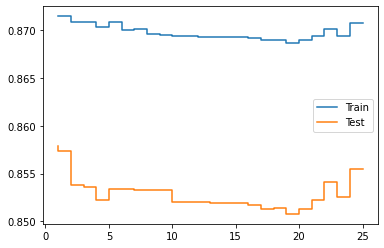

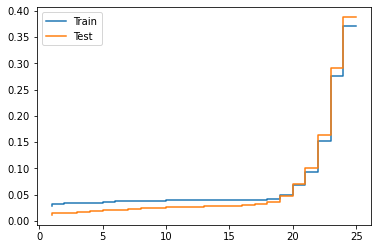

In [9]:
import matplotlib.pyplot as plt

plt.step(x = time, y = tv_c_index_train)
plt.step(x = time, y = tv_c_index_test1)
plt.legend(['Train', 'Test'])
plt.show()

plt.step(x = time, y = tv_brier_train)
plt.step(x = time, y = tv_brier_test1)
plt.legend(['Train', 'Test'])
plt.show()

In [6]:
tv_c_index_test1

[0.7051658966820663,
 0.7019520479155634,
 0.6957990704326064,
 0.6939578119413657,
 0.6925634608509117,
 0.6972291741151233,
 0.6963711119056132,
 0.6934572756524848,
 0.6898462638541294,
 0.6897568823739721,
 0.69465471684639,
 0.6939584374776834,
 0.6924944654716846,
 0.6931371848889524,
 0.6924298665143837,
 0.6917874223713327,
 0.6909308301805982,
 0.6890748804340067,
 0.6885752016560782,
 0.6922335641373403,
 0.6892176457991291,
 0.6850417588692983,
 0.686201727460918,
 0.711792419159112,
 0.7141302020129916]